## 1. Autoencoder
*     Reference. https://dacon.io/codeshare/4551
*     FashionMNIST dataset

#### (1) Extract latent vectors & Reconstruct image w/ Autoencoder (AE)

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [2]:
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [3]:
trainset = datasets.FashionMNIST(. # loading training data from FashionMNIST
    root      = './.data/',
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2  # ???
)

100%|██████████| 26421880/26421880 [00:02<00:00, 11934755.01it/s]


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 203028.30it/s]


Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3717875.40it/s]


Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20331710.92it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder (input: 28*28 image -> 3 as a latent vector)
        # 28x28 size의 input image data를 size 3의 latent vector로 dimension reduction하는 encoder
        self.encoder = nn.Sequential(.
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),
        )
        # Decoder (from latent vector (size: 3) -> decode it to 28*28 size image)
        # size 3의 latent vector를 다시 28x28 size의 image data로 reconstruct
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [5]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss(). # use MSE function for reconstruction error

In [6]:
view_data = trainset.data[:5].view(-1, 28*28). # training data set의 처음 5개의 data를 보여줌
view_data = view_data.type(torch.FloatTensor)/255.  # normalizing pixel values to [0, 1]

In [7]:
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE). # target이 input이랑 같음
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x). # forward pass

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

[Epoch 1]


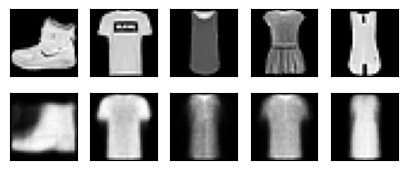

[Epoch 2]


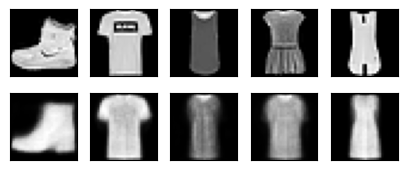

[Epoch 3]


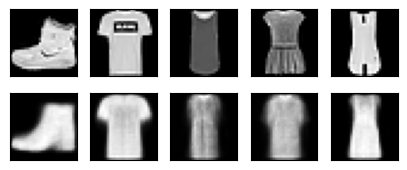

[Epoch 4]


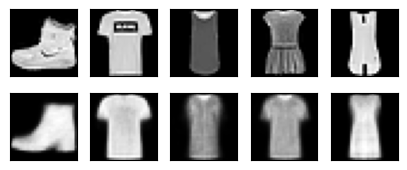

[Epoch 5]


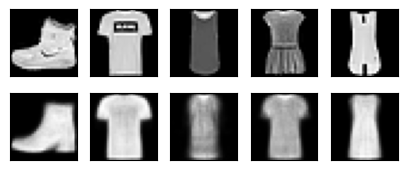

[Epoch 6]


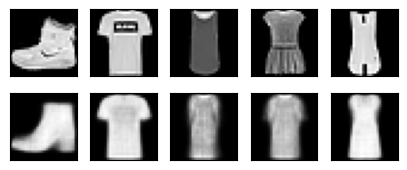

[Epoch 7]


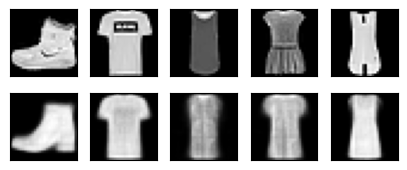

[Epoch 8]


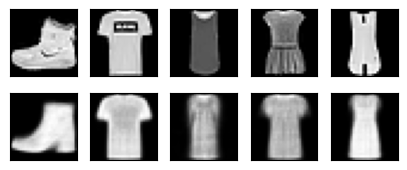

[Epoch 9]


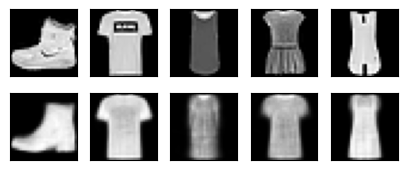

[Epoch 10]


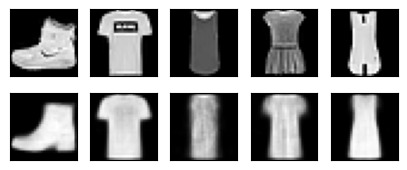

In [8]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    # input image를 visualize
    f, a = plt.subplots(2, 5, figsize=(5, 2)). #matplotlib figure with 2 rows and 5 columns
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28, 28))
        # flat한 numpy 형태의 data를 28x28 size의 data로 reshape
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    #  decoder를 통한 reconstructed image를 visualize
    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

#### (2) Image Denoising w/ AE

In [9]:
def add_noise(img):  # add noise to the input image
    noise = torch.randn(img.size()) * 0.2. # noise intensity를 조절 (0.2)
    noisy_img = img + noise  # 원래 image data에 noise를 더해줌
    return noisy_img

In [10]:
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        noisy_x = add_noise(x)
        noisy_x = noisy_x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)

        label = label.to(DEVICE)
        encoded, decoded = autoencoder(noisy_x) # noise가 더해진 data를 사용하여 학습

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
    return avg_loss / len(train_loader)

In [11]:
for epoch in range(1, EPOCH+1):
    loss = train(autoencoder, train_loader)
    print("[Epoch {}] loss:{}".format(epoch, loss))

[Epoch 1] loss:0.023169956777665788
[Epoch 2] loss:0.02261787663295325
[Epoch 3] loss:0.022650516738912573
[Epoch 4] loss:0.022353846011862064
[Epoch 5] loss:0.022280099166275213
[Epoch 6] loss:0.02220924417061338
[Epoch 7] loss:0.022108089720913722
[Epoch 8] loss:0.022077544949758155
[Epoch 9] loss:0.02198620620114145
[Epoch 10] loss:0.021937923851424953


In [12]:
testset = datasets.FashionMNIST(
    root      = './.data/',
    train     = False, # training data와 다른 test data
    download  = True,
    transform = transforms.ToTensor()
)

sample_data = testset.data[0].view(-1, 28*28). # test data의 첫번째 이미지를 선택해서 reshape
sample_data = sample_data.type(torch.FloatTensor)/255.

original_x = sample_data[0] # 첫번째 sample을 선택
noisy_x = add_noise(original_x).to(DEVICE) # 해당 sample에 add noise
_, recovered_x = autoencoder(noisy_x)

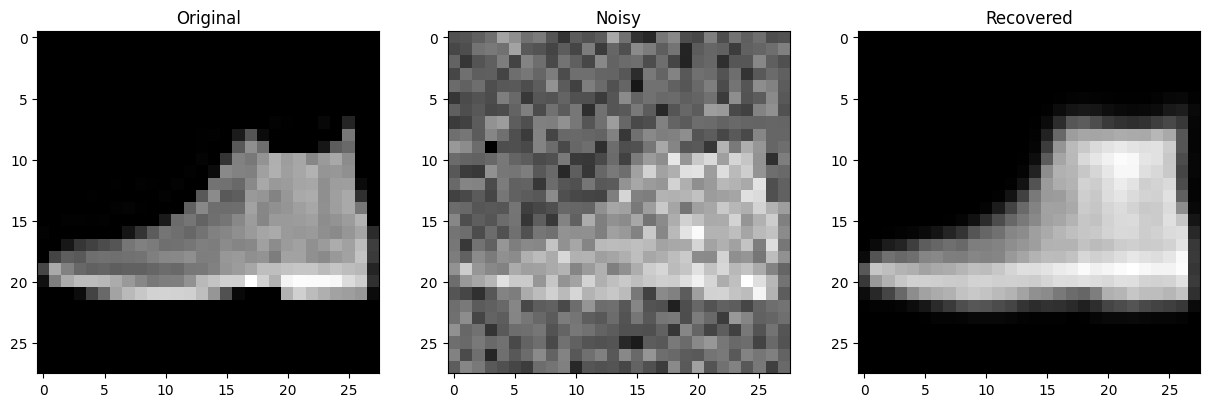

In [13]:
f, a = plt.subplots(1, 3, figsize=(15, 15))

original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

# original image
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

# original image w/ noise
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# recoveredimage
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()

### Question 1. Explain the code of the '1. Autoencoder' section "briefly".

## 2. Principal Component Analysis [PCA]
*    Reference. https://romg2.github.io/mlguide/12_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-06.-%EC%B0%A8%EC%9B%90%EC%B6%95%EC%86%8C-PCA/



#### Question 2. What is PCA in "mathematical" perspective? Google it and write your own answer.

PCA (Principal Component Analysis) : 주성분 분석

PCA는 고차원의 데이터를 저차원의 데이터로 환원시키는 dimensionality reduction에 사용되는 기법이다. 중요한 것은 데이터의 차원을 축소시킬 때 어떻게 해야 "잘" 축소시킬 수 있을지 생각해보는 것인데, PCA는 데이터들이 최대한 멀리 떨어질 수 있게 하는 축을 찾아 그 축으로 기준으로 데이터를 재구성한다 . 최대한 데이터들이 서로 멀리 떨어져서 표현된다는 것은 각 데이터들의 구분되는 feature들을 잘 표현할 수 있다는 것을 의미하기 때문이다. 따라서 PCA는 공분산 행렬의 고유값 분해를 통해 데이터의 분산을 최대화하는 새로운 축을 찾고, 데이터를 이 축으로 변환하여 차원을 축소한다.

PCA는 다음과 같은 과정으로 진행된다.
1. 데이터의 평균이 0이 되도록 표준화시켜준다.
2. 데이터의 공분산 행렬을 계산한다.
3. 공분산 행렬의 고유값과 고유벡터를 계산한다.
4. 고유값이 큰 순서대로 고유벡터를 정렬하고, 상위 k개의 고유벡터를 선택한다. (k차원으로 변환할 경우)
5. 선택한 고유벡터들을 축으로 데이터를 변환한다.



In [14]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic')
mpl.rc('axes', unicode_minus=False)

sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

In [16]:
from sklearn.datasets import load_iris

iris = load_iris()

columns = ['sepal_length','sepal_width','petal_length','petal_width']
iris_df = pd.DataFrame(data = iris.data, columns = columns)
iris_df["target"] = iris.target

iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


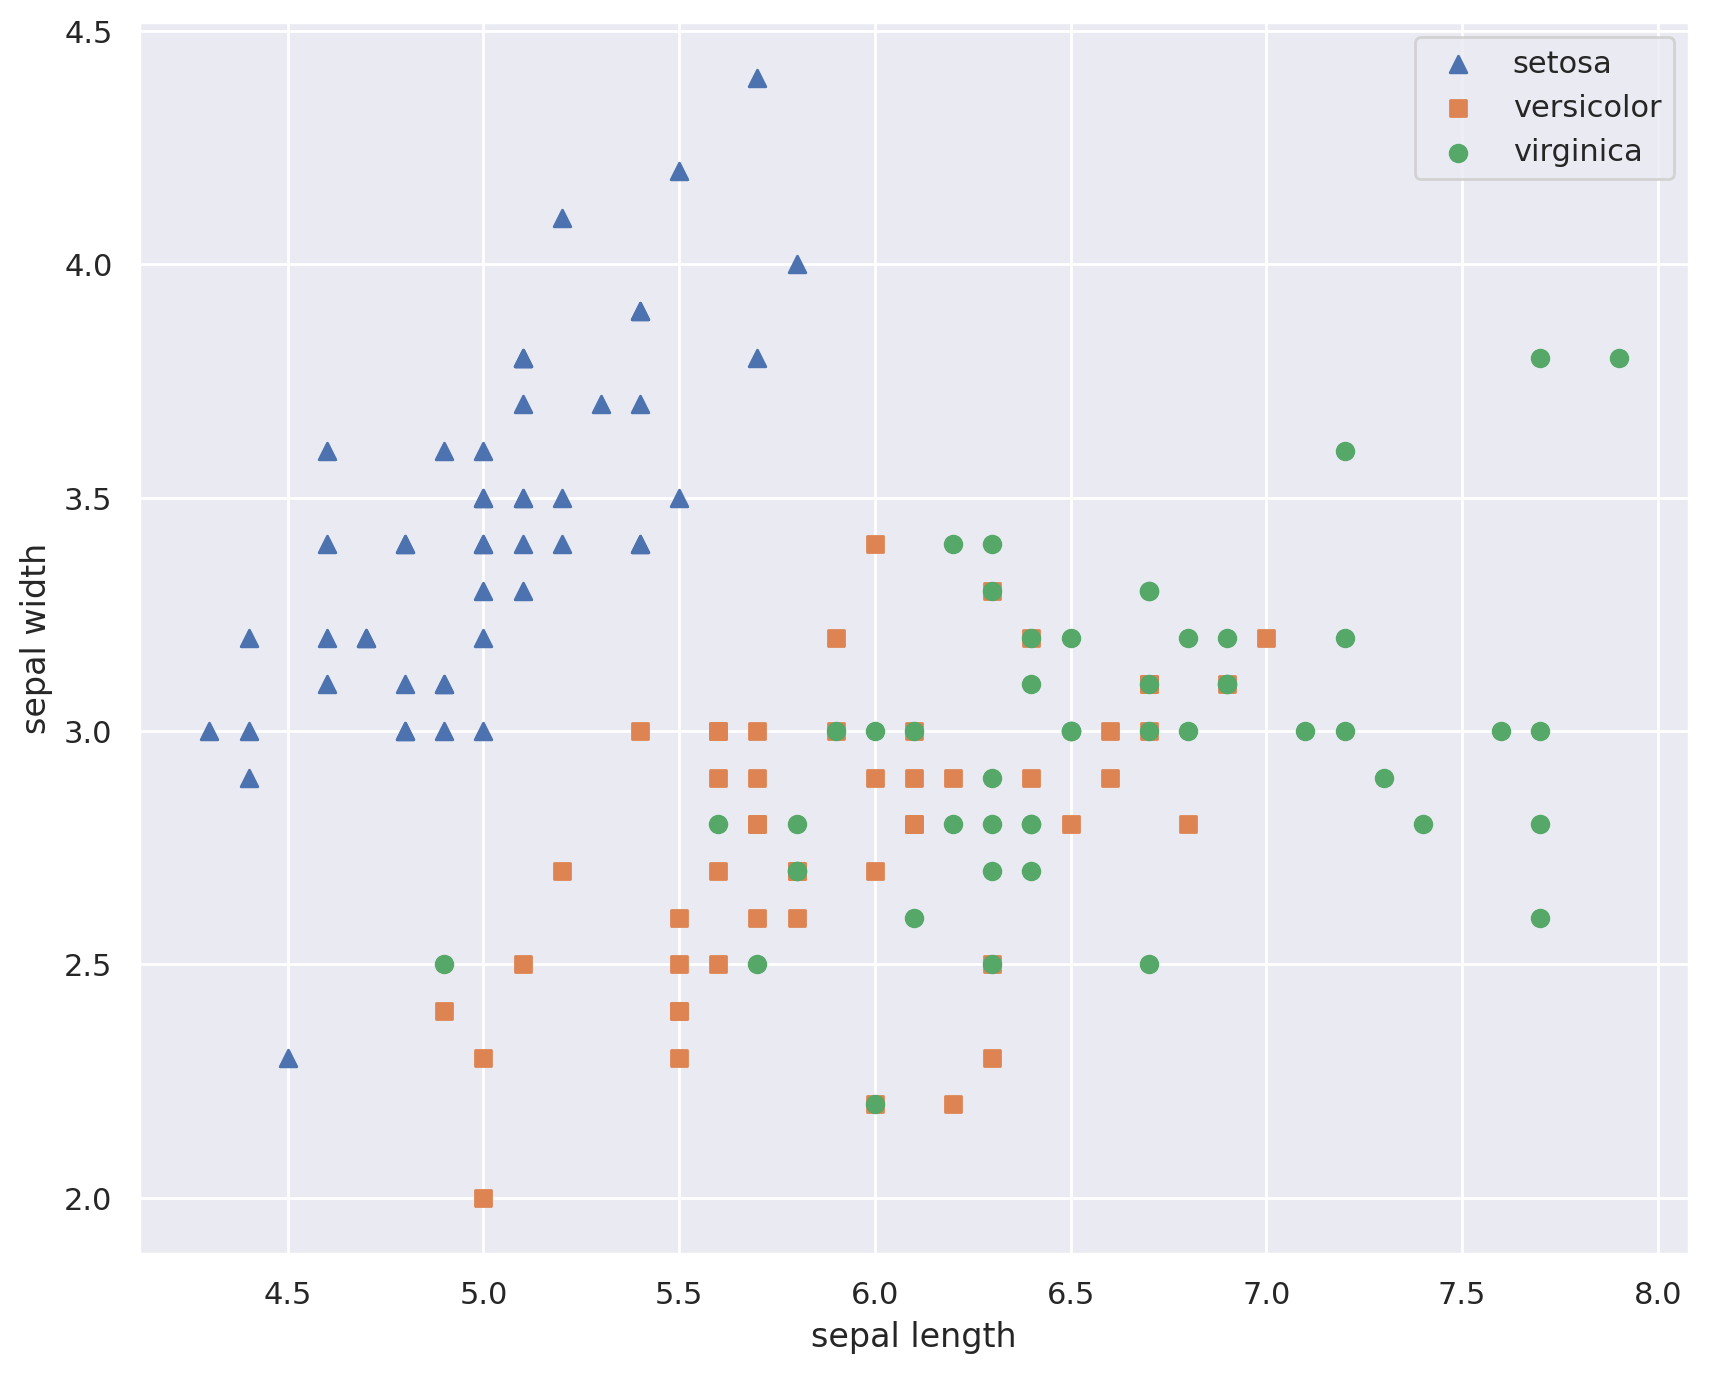

In [17]:
markers = ["^", "s", "o"]

# 0:setosa, 1:versicolor, 2:virginica
for i, marker in enumerate(markers):
    x_axis_data = iris_df[iris_df['target']==i]['sepal_length']
    y_axis_data = iris_df[iris_df['target']==i]['sepal_width']
    plt.scatter(x_axis_data, y_axis_data, marker=marker, label=iris.target_names[i])

plt.legend()
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.show()

In [18]:
from sklearn.preprocessing import StandardScaler

iris_f_scaled = StandardScaler().fit_transform(iris_df.iloc[:,:-1])

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2) # of principal components = 2

pca.fit(iris_f_scaled)
iris_pca = pca.transform(iris_f_scaled)

print(f"scaled: {iris_f_scaled.shape}")
print(f"pca: {iris_pca.shape}")

scaled: (150, 4)
pca: (150, 2)


In [20]:
pca_columns=['pca_component_1','pca_component_2']

iris_df_pca = pd.DataFrame(iris_pca, columns = pca_columns)
iris_df_pca['target'] = iris.target

iris_df_pca.head(3)

,pca_component_1,pca_component_2,target
0,-2.264703,0.480027,0
1,-2.080961,-0.674134,0
2,-2.364229,-0.341908,0


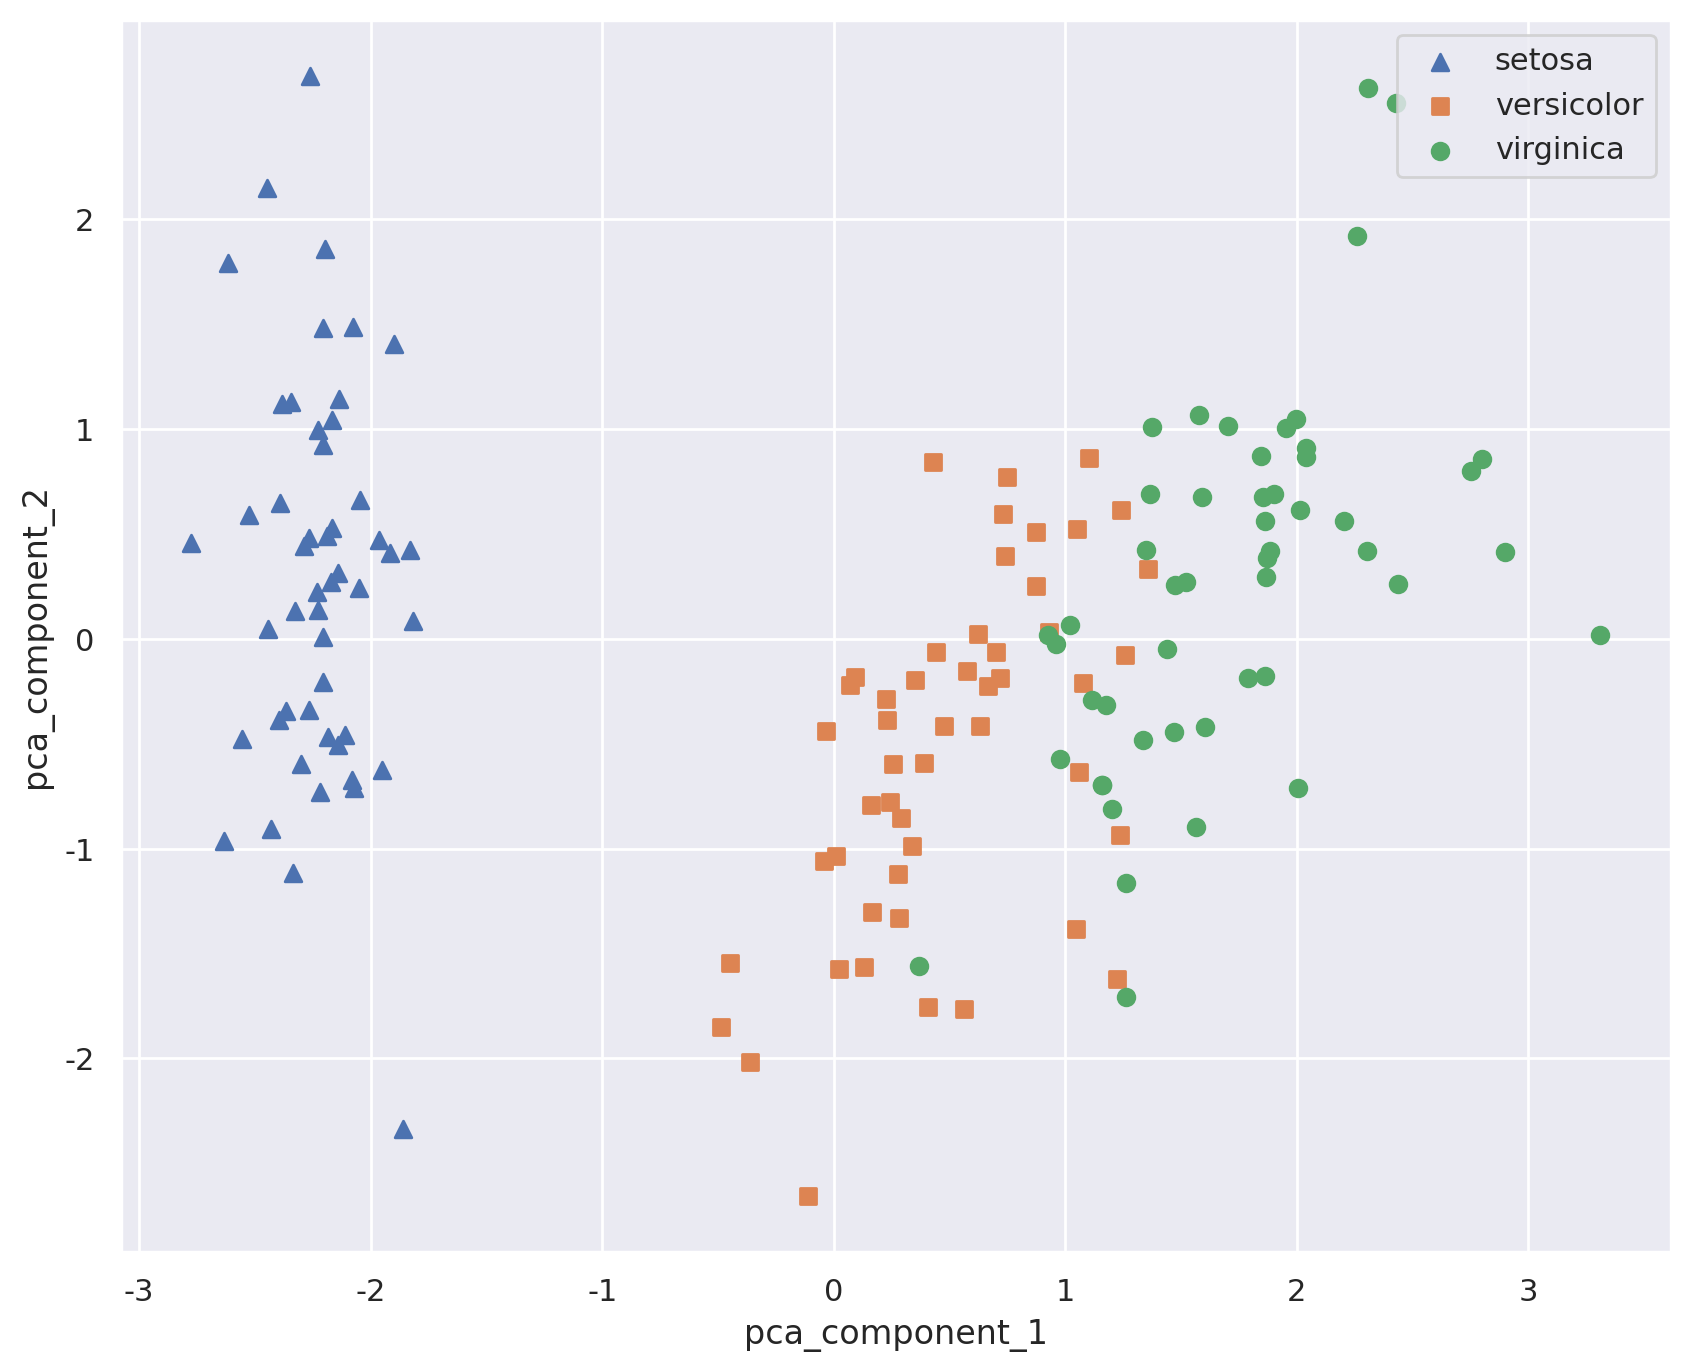

In [21]:
markers = ["^", "s", "o"]

# 0:setosa, 1:versicolor, 2:virginica
for i, marker in enumerate(markers):
    x_axis_data = iris_df_pca[iris_df_pca['target']==i]['pca_component_1']
    y_axis_data = iris_df_pca[iris_df_pca['target']==i]['pca_component_2']
    plt.scatter(x_axis_data, y_axis_data, marker=marker,label=iris.target_names[i])

plt.legend()
plt.xlabel('pca_component_1')
plt.ylabel('pca_component_2')
plt.show()

In [22]:
print(pca.explained_variance_ratio_) ## Although we implemented PCA, we can still explain majority of the data

[0.72962445 0.22850762]


### Question 3.
### Autoencoder reduces the dimension of the data w/ deep learning methods.
### PCA does the same thing in mathematically linear way.
### In this context, Autoencoder is a _ _ _ _ _ _ _ _ _ PCA.
### Hint: n _ _ l _ _ _ _ _

answer : nonlinear